### CAA freshwater content

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
import os
from itertools import compress
import datetime as dt
from datetime import date
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
from math import sin, cos, sqrt, atan2, radians
import warnings
import seaborn as sns
from dateutil.relativedelta import relativedelta
import glob
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
import sys
sys.path.insert(0, '/ocean/brogalla/GEOTRACES/analysis-brogalla/modules')
import ariane as ar

##### Parameters:

In [4]:
# Domain dimensions:
imin, imax = 1480, 2180
jmin, jmax = 160, 800
isize = imax - imin
jsize = jmax - jmin

# Results folders:
folder_ref = '/data/brogalla/run_storage/Mn-set4-202004/'
folder_sed = '/data/brogalla/run_storage/Mn-nosed-202005/'
folder_riv = '/data/brogalla/run_storage/riv-2a-202005/'
folder_con = '/data/brogalla/run_storage/riv-2b-202005/'

# Color map:
N = 256
vals_cont = np.ones((N, 4))
vals_cont[:, 0] = np.linspace(164/N, 1, N)
vals_cont[:, 1] = np.linspace(116/N, 1, N)
vals_cont[:, 2] = np.linspace(84/N, 1, N)
cont_cmap = ListedColormap(vals_cont).reversed()

vals_glac = np.ones((N, 4))
vals_glac[:, 0] = np.linspace(113/N, 1, N)
vals_glac[:, 1] = np.linspace(169/N, 1, N)
vals_glac[:, 2] = np.linspace(144/N, 1, N)
glac_cmap = ListedColormap(vals_glac).reversed()

vals_both = np.ones((N, 4))
vals_both[:, 0] = np.linspace(89/N, 1, N); 
vals_both[:, 1] = np.linspace(89/N, 1, N)
vals_both[:, 2] = np.linspace(89/N, 1, N)
both_cmap = ListedColormap(vals_both).reversed()

##### Load files:

In [5]:
# Meshmasks
mask      = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask     = np.array(mask.variables['tmask'])
land_mask = np.ma.masked_where((tmask[0,:,:,:] > 0.1) , tmask[0,:,:,:]) 

tmask_full    = np.empty((12,50,isize,jsize))
tmask_full[:] = tmask[0,:,imin:imax,jmin:jmax]

mesh  = nc.Dataset('/data/brogalla/old/meshmasks/ANHA12_mesh1.nc')
lon   = np.array(mesh.variables['nav_lon'])
lat   = np.array(mesh.variables['nav_lat'])
mesh_bathy = np.array(mesh.variables['hdept'][0])

In [6]:
ref   = nc.Dataset('/data/brogalla/run_storage/Mn-set4-202004/ref-2002/ANHA12_EXH006_2002_monthly.nc',  'r')
lons  = np.array(ref.variables['nav_lon'])
lats  = np.array(ref.variables['nav_lat'])
depth = np.array(ref.variables['deptht'])

##### Functions:

In [7]:
def calculate_diff(year):
    
    files_base  = np.sort(glob.glob(folder_ref+'ref-'   +str(year)+'/ANHA12_EXH006_5d*'))
    files_glac  = np.sort(glob.glob(folder_riv+'riv-2a-'+str(year)+'/ANHA12_EXH006_5d*'))
    files_cont  = np.sort(glob.glob(folder_con+'riv-2b-'+str(year)+'/ANHA12_EXH006_5d*'))
    files_nosed = np.sort(glob.glob(folder_sed+'nosed-' +str(year)+'/ANHA12_EXH006_5d*'))

    glacier_contribution   = np.empty((len(files_base),50,isize,jsize))
    continent_contribution = np.empty((len(files_base),50,isize,jsize))
    sediment_contribution  = np.empty((len(files_base),50,isize,jsize))
    
    for file_ind in range(0,len(files_base)):
        base_fday  = nc.Dataset(files_base[file_ind]);
        glac_fday  = nc.Dataset(files_glac[file_ind]);
        cont_fday  = nc.Dataset(files_cont[file_ind]);
        nosed_fday = nc.Dataset(files_nosed[file_ind]);

        dmn_base  = np.array(base_fday.variables['dissolmn'])[0,:,:,:]
        dmn_glac  = np.array(glac_fday.variables['dissolmn'])[0,:,:,:]
        dmn_cont  = np.array(cont_fday.variables['dissolmn'])[0,:,:,:]
        dmn_nosed = np.array(nosed_fday.variables['dissolmn'])[0,:,:,:]

        glacier_contribution[file_ind,:,:,:]   = dmn_glac - dmn_base
        continent_contribution[file_ind,:,:,:] = dmn_cont - dmn_base
        sediment_contribution[file_ind,:,:,:]  = dmn_base - dmn_nosed
    
    return glacier_contribution, continent_contribution, sediment_contribution

In [8]:
def file_dates(year):
    #start_date and end_date are datetime objects
    start_date = dt.datetime(year,1,1)
    end_date   = dt.datetime(year,12,31,12)
    
    file_list1E = np.sort(os.listdir('/data/brogalla/run_storage/Mn-set4-202004/ref-'+str(year)+'/'))
    file_list2 = np.sort(os.listdir('/data/brogalla/ANHA12/'))
    
    Vlist = [i[26:31]=='gridV' for i in file_list2]
    gridV_list = list(compress(file_list2, Vlist))
    dateV_list = [dt.datetime.strptime(i[14:25], "y%Ym%md%d") for i in gridV_list]
    gridV_file_list = list(compress(gridV_list, [V > start_date and V < end_date for V in dateV_list]))
    
    dates = [dt.datetime.strptime(i[14:25], "y%Ym%md%d") for i in gridV_file_list]
    
    return dates

##### Calculations:

Create mask for CAA

In [9]:
mask_ini_CAA  = np.ones(lon.shape) # full domain size
mask_ini_CAA[0:imin+10, :] = 0 # remove the boundaries
mask_ini_CAA[imax-10:, :]  = 0
mask_ini_CAA[:, 0:jmin]    = 0
mask_ini_CAA[:, jmax-20:]  = 0

# Define CAA using the longitudes
mask_CAA = np.ma.masked_where((mesh_bathy > 800), mask_ini_CAA)
mask_CAA = np.ma.masked_where(lon < -130, mask_CAA)

mask_CAA_lons = np.ma.masked_where(mask_CAA==0, lon)
mask_CAA_lats = np.ma.masked_where(mask_CAA==0, lat)

mask_CAA_yr   = np.tile(mask_CAA[imin:imax,jmin:jmax], (73,50,1,1))

Calculate the continental Mn contribution to Canada Basin over time:

In [ ]:
timeseries_glac = []
timeseries_cont = []
timeseries_ice  = []

for year in range(2002, 2020):
    print(year)
    glacier, cont, sed = calculate_diff(year)
    glacier_CAA    = np.ma.masked_where(mask_CAA_yr==0, glacier)
    cont_CAA       = np.ma.masked_where(mask_CAA_yr==0, cont)
    sedice_CAA     = np.ma.masked_where(mask_CAA_yr==0, sed)
    
    for fday in range(0,73):
        glac_sum = np.ma.sum(glacier_CAA[fday,:,:,:])
        cont_sum = np.ma.sum(cont_CAA[fday,:,:,:])
        sed_sum  = np.ma.sum(sedice_CAA[fday,:,:,:])

        timeseries_glac.append(glac_sum)
        timeseries_cont.append(cont_sum)
        timeseries_ice.append(sed_sum)
        
pickle.dump((timeseries_glac, timeseries_cont, timeseries_ice), \
            open('/ocean/brogalla/GEOTRACES/pickles/CAA_timeseries.pickle','wb'))

In [10]:
dates = np.array([file_dates(year) for year in range(2002,2020)]).flatten()

In [11]:
ts_glac, ts_cont, ts_ice = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/CAA_timeseries.pickle', 'rb'))
ts_glac = np.array(ts_glac)
ts_cont = np.array(ts_cont)
ts_ice  = np.array(ts_ice)

In [12]:
rf = np.empty((19*12, imax-imin, jmax-jmin))
i  = 0
for year in range(2002, 2020):
# for year in range(2002, 2005):
    for month in range(0,12):
        c = nc.Dataset('/data/brogalla/runoff/ANHA12_runoff_monthly_combined_Dai_Trenberth_Bamber_y'+str(year)+'.nc','r')
        rf[i*12+month,:,:] = np.array(c.variables['runoff'])[month,imin:imax,jmin:jmax]
        
    i+=1

In [13]:
mask_CAA_rf = np.tile(mask_CAA[imin:imax,jmin:jmax], (228,1,1))
rf_dates    = np.array([dt.datetime(2002,1,1) + relativedelta(months=+i) for i in range(0,228)])
rf_CAA      = np.ma.sum(np.ma.masked_where(mask_CAA_rf==0, rf), axis=(1,2))

## Figures

In [14]:
ccont = '#ce9169'
cice  = '#a1b8c4'
cglac = '#36ab92'

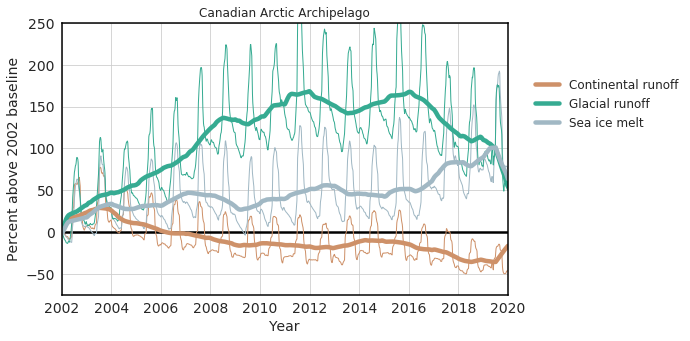

In [20]:
fig = plt.figure(figsize=(8,5))
st  = sns.axes_style("whitegrid")

cont = np.array(ts_cont - ts_cont[0])*100/ts_cont[0]
ice  = np.array(ts_ice - ts_ice[0])*100/ts_ice[0]
skip_yrs = 0
glac = np.array(ts_glac[skip_yrs:] - ts_glac[skip_yrs])*100/np.abs(ts_glac[skip_yrs])

with st:
    
    ax = sns.lineplot([dates[0], dates[-1]], [0, 0], c='k', linewidth=2.5)
    
    # Five day files: (Thin lines)
    sns.lineplot(dates, cont, linewidth=1, color=ccont, ax=ax)
    sns.lineplot(dates, ice, linewidth=1, color=cice, ax=ax)
    sns.lineplot(dates[skip_yrs:], glac, linewidth=1, color=cglac, ax=ax)
  
    # Moving average 
    N = 73
    cont_ave = np.convolve(cont, np.ones((N,))/N, mode='same')
    ice_ave  = np.convolve(ice , np.ones((N,))/N, mode='same')
    glac_ave = np.convolve(glac, np.ones((N,))/N, mode='same') # moving average
    sns.lineplot(dates[len(cont)-len(cont_ave):], cont_ave, color=ccont, linewidth=4.5, label=r'Continental runoff')
    sns.lineplot(dates[skip_yrs:], glac_ave, color=cglac, linewidth=4.5, label=r'Glacial runoff')
    sns.lineplot(dates[len(ice) -len(ice_ave):], ice_ave, color=cice, linewidth=4.5, label=r'Sea ice melt')
    
    # River discharge sum:
#     sns.lineplot(rf_dates, rf_CAA*30, linewidth=2.5, color='k', ax=ax)
    
    # Other figure settings
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('Percent above 2002 baseline',fontsize=14)
    ax.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2020,1,1)))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set(ylim=(-75,250))
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');  
    
    ax.set_title('Canadian Arctic Archipelago')
    leg  = ax.legend(loc=(1.05, 0.59), frameon=True, framealpha=0.7, fontsize=12)
    leg.get_frame().set_linewidth(0.0)
    
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers/R6-CAA-runoff-'+ \
#             str(date.today().strftime('%Y%m%d')) + '.png', bbox_inches='tight',dpi=300)

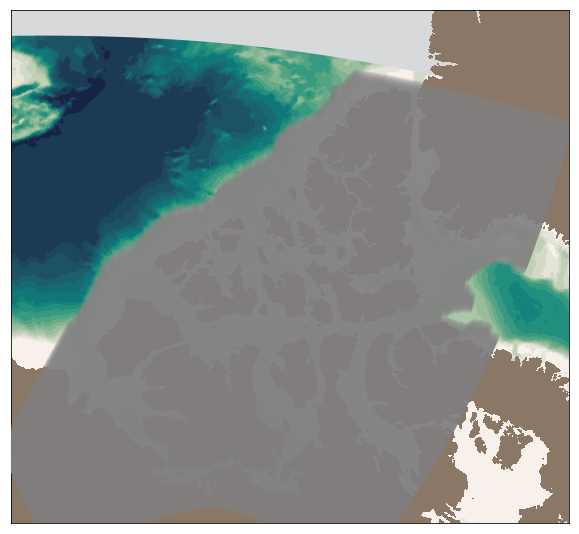

In [17]:
fig, ax1 = plt.subplots(figsize=(10,12))

proj2 = Basemap(projection='stere',lat_0 = 77, lon_0 = -100, resolution='i', width=2.5e6, height=2.3e6, ax=ax1)

x_land, y_land = proj2(lon, lat)

proj2.contourf(x_land, y_land, mesh_bathy, 20, cmap=cmocean.cm.tempo, vmin=0, vmax=4000, zorder=1)
proj2.contourf(x_land[:,:], y_land[:,:], land_mask[10,:,:], \
               cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=2)

# Draw domain boundaries:
proj2.plot(x_land[imax:-1,:] , y_land[imax:-1,:] , \
           '-', color='#d8d9da', linewidth=10, zorder=1)
proj2.plot(x_land[:,jmax:-1] , y_land[:,jmax:-1] , \
           '-', color='#d8d9da', linewidth=10, zorder=1)

# CAA region definition:
x_CAA, y_CAA = proj2(mask_CAA_lons, mask_CAA_lats)
proj2.plot(x_CAA, y_CAA, '-', color='#818282', linewidth=10, zorder=4, alpha=0.2);

fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers/R6-domain-definition.png', bbox_inches='tight', dpi=300)